In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# Load data
train_X = pd.read_csv("C:/Users/Anorm/Downloads/train_X.csv.zip", index_col=0)
train_y = pd.read_csv("C:/Users/Anorm/Downloads/train_y.csv")
test_X = pd.read_csv("C:/Users/Anorm/Downloads/test_X.csv.zip")

train_X.isnull().any().sum()
train_y.isnull().any().sum()
test_X.isnull().any().sum()
# Preprocess
gene_names = train_X.columns[1:]
X = train_X  
y = train_y.iloc[:, 1]  # Use the second column as labels
X_test = test_X.drop(test_X.columns[0], axis=1)
# Verify shapes
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X_test shape:", X_test.shape)

X.isnull().any().sum()

y.isnull().any().sum()

X_test.isnull().any().sum()


X shape: (444, 17970)
y shape: (444,)
X_test shape: (110, 17970)


0

I loaded the different data sets in and dropped the ID names column on the train_x and test_x datsets. I also checked the shapes and checked for missing values.

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

I then scaled the data so that I could perform linear regression.

In [8]:
from sklearn.model_selection import GridSearchCV


param_grid = {'solver': ['liblinear'], 'penalty': ['l1'], 'C': [.001,0.01,0.1,1,10,100],'max_iter':[100,500,1000,10000]}


L1_Logistic = LogisticRegression()

grid_search_l1= GridSearchCV(L1_Logistic, param_grid, cv=5,scoring='f1_macro')
grid_search_l1.fit(X_scaled, y)


print('Best Optimal hyperparameter combination:', grid_search_l1.best_params_, 'F1 score:', round(grid_search_l1.best_score_, 4))
best_l1_model = grid_search_l1.best_estimator_

Best Optimal hyperparameter combination: {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'} F1 score: 0.813


I originally tried running linear, Lasso, ridge, and logistic regression, but all the ones besides logistic were not directly suitable for binary data output as the response variable. So instead of creating different spreads that would map a certain range of numbers that are above a certain number to ones and the valuess below to zeroes for a less optimal method, I just went with logistic and then used Lasso and Ridge as regulators in addition to regular logistic regression. This logistic model with LASSO regularization performed the best, outputting the best F1 score, out of the three, and I used it in the Kaggle to check the accuracy, which was above 90%.

In [9]:
param_grid = {'solver': ['liblinear'], 'penalty': ['l2'], 'C': [0.001,0.01, 0.1, 1,10,100],'max_iter':[100,500,1000,10000]}

L2_logistic = LogisticRegression()

grid_search_l2 = GridSearchCV(L2_logistic, param_grid, cv=5,scoring='f1_macro')
grid_search_l2.fit(X_scaled, y)


print('Best Optimal hyperparameter combination:', grid_search_l2.best_params_, 'F1 score:', round(grid_search_l2.best_score_, 4))
best_l2_model = grid_search_l2.best_estimator_

Best Optimal hyperparameter combination: {'C': 0.001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'} F1 score: 0.8058


Logisitc regression with ridge regularization ran pretty similar to Lasso, it just took longer to run as well as putting out a slightly lower value for F1 score. 

In [10]:

param_grid = {
    'solver': ['liblinear'],  
    'C': [0.001,0.01, 0.1, 1, 10, 100],  
    'max_iter': [100,500,1000,10000]  
}


logistic_model = LogisticRegression()


grid_search_standard = GridSearchCV(logistic_model, param_grid, cv=5, scoring='f1_macro')


grid_search_standard.fit(X_scaled, y)


print('Best Optimal hyperparameter combination:', grid_search_standard.best_params_, 
      'F1 score:', round(grid_search_standard.best_score_, 4))
best_standard_model = grid_search_standard.best_estimator_

Best Optimal hyperparameter combination: {'C': 0.001, 'max_iter': 100, 'solver': 'liblinear'} F1 score: 0.8058


Regular logistic regression also performed slightly worse than Lasso regularization and took a couple minutes longer. Gridsearch found the hyperparameters to be the same optimal ones for regular logistic and Ridge logistic, while it chose a different value of C for Lasso.

In [11]:
y_randomized = np.random.permutation(y)

y_pred_random = best_l1_model.predict(X_scaled)

random_accuracy = accuracy_score(y_randomized, y_pred_random)
print(f"Random Guessing Accuracy: {random_accuracy:.4f}")

Random Guessing Accuracy: 0.5225


I scrambled the y's and tested my best models accuracy on it. It sits around 50% which makes good sense. This is opposed to the 90% the model performed on the Kaggle test set. 

In [12]:

coefficients = best_l1_model.coef_[0]

# Create a DataFrame for importance analysis
importance_df = pd.DataFrame({'Gene': X.columns, 'Coefficient': coefficients})
importance_df['Abs_Coefficient'] = importance_df['Coefficient'].abs()
importance_sorted = importance_df.sort_values(by='Abs_Coefficient', ascending=False)

# Display top important genes
print(importance_sorted.head(10))

                  Gene  Coefficient  Abs_Coefficient
15816  ENSG00000198812    -0.530335         0.530335
13265  ENSG00000177947     0.451836         0.451836
16773  ENSG00000221813    -0.451334         0.451334
6937   ENSG00000136535     0.386605         0.386605
13574  ENSG00000180316     0.372773         0.372773
9154   ENSG00000153714    -0.371417         0.371417
11497  ENSG00000168148    -0.355073         0.355073
16161  ENSG00000204928    -0.352945         0.352945
7786   ENSG00000141968     0.328314         0.328314
8119   ENSG00000144290     0.327033         0.327033


This ranks the most important genes based on the absolute value of their coefficient which measures its predictive ability.

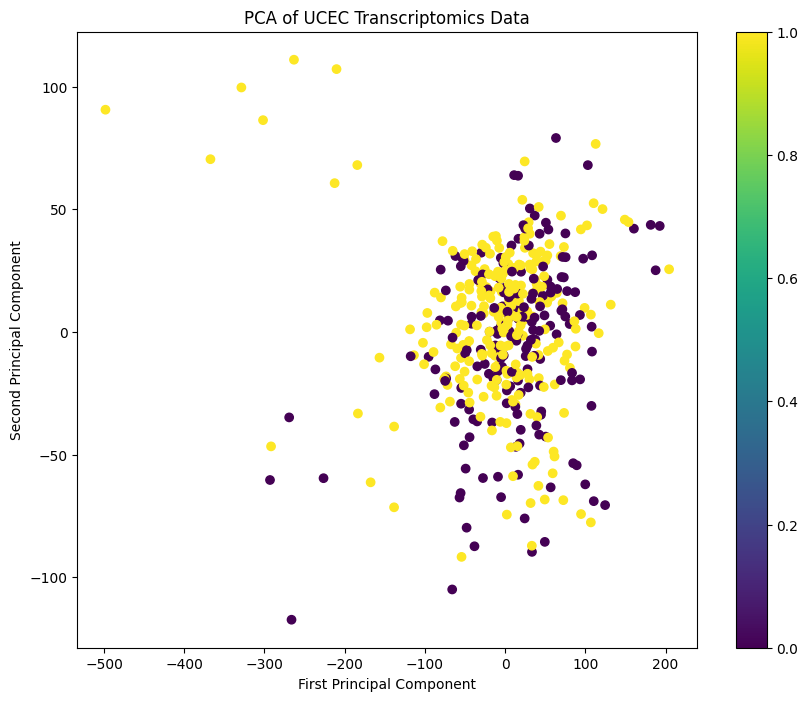

In [13]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.colorbar(scatter)
plt.title('PCA of UCEC Transcriptomics Data')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

Using PCA, I tried to visualize the dataset and find two separate groups, but the visual seems to show that there is not two groups that are obviously separated as the clusters overlap each other. 

In [14]:
predictions = best_l1_model.predict(X_test_scaled)
print(predictions)

[1 0 0 1 0 1 1 0 0 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1
 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1
 1 0 1 1 0 0 0 1 1 1 1 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 0 0 0]


Used the best model from above, the logistic with lasso regularization, to predict binary values for the x_test dataset.

In [15]:
# Create a DataFrame for submission
submission_df = pd.DataFrame({
    'ID': test_X.iloc[:, 0],  # Select the first column directly
    'xml_neoplasm_histologic_grade': predictions
})

submission_df.to_csv('submission.csv', index=False)

I then created a dataframe that will be able to be placed into kaggle for the competition.

In conclusion, I found the logistic regression to be the most applicable to this dataset. I used regular, Lasso, and Ridge regularizations, and used gridsearch to find the best hyperparameters to use for the model. Lasso put out the best F1 score.  I think, realistically, it is possible that there are other methods other than linear models that could do a better job of classifying the dataset. 